# 프로젝트 : 번역기를 만들어보자

**예전부터 번역기를 한 번 만들어보고 싶었습니다.**

## 1. 데이터 준비하기
- **데이터 불러오기**
- **데이터 전처리**
- **데이터 로더 함수 설계하기**

## 2. 단어 Level 번역기 만들기
- **모델 설계하기**
- **모델 훈련하기**

## 3. 번역기 성능 확인하기

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import os, re

- - -
### 데이터 준비하기
- **데이터 불러오기**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/MyDrive/Colab Notebooks/exp/translator/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')

print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
39299,Turn down the radio.,Baissez la radio.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
197323,I can't believe that you aren't at least willi...,Je n'arrive pas à croire que vous ne soyez pas...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
29170,He lost everything.,Il a tout perdu.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
171880,She seems to have left for Tokyo yesterday.,Elle semble être partie pour Tokyo hier.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
192291,Do you spend more time with your friends or wi...,Passes-tu davantage de temps avec tes amis ou ...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


준비된 데이터를 불러옵니다.

In [4]:
lines = lines[['eng', 'fra']]
lines.loc[lines['eng']=='Hello!']

,eng,fra
50,Hello!,Bonjour !
51,Hello!,Salut !


영어와 프랑스어 컬럼을 제외한 나머지 컬럼은 빼주고

'Hello!'와 같은 뜻을 가진 프랑스어를 찾아봤습니다.

두 개가 나오네요.

- - -
### 데이터 준비하기
- **데이터 전처리**

In [5]:
preprocess_sentence = lambda x: re.sub(r"([?.!,¿])", r" \1 ", x.lower()).split()

preprocess_sentence('he is a good boy!')

['he', 'is', 'a', 'good', 'boy', '!']

구두점 분리를 위한 정규표현식입니다.

In [6]:
eng_token = lines['eng'].apply(preprocess_sentence)
fra_token = lines['fra'].apply(preprocess_sentence)

print(eng_token)
print(fra_token)

0                                                   [go, .]
1                                                   [go, .]
2                                                   [go, .]
3                                                   [go, .]
4                                                   [hi, .]
                                ...                        
197458    [a, carbon, footprint, is, the, amount, of, ca...
197459    [death, is, something, that, we're, often, dis...
197460    [since, there, are, usually, multiple, website...
197461    [if, someone, who, doesn't, know, your, backgr...
197462    [it, may, be, impossible, to, get, a, complete...
Name: eng, Length: 197463, dtype: object
0                                                   [va, !]
1                                               [marche, .]
2                                            [en, route, !]
3                                                [bouge, !]
4                                                [salut, !]

구두점 분리가 잘 적용되는 것 같습니다.

하면서 공백을 기준으로 단어를 분리해봤습니다.

In [7]:
# 시작 토큰과 종료 토큰 추가
sos_token = '\t'
eos_token = '\n'
fra_token = fra_token.apply(lambda x: [sos_token] + x + [eos_token])

fra_token

0                                           [\t, va, !, \n]
1                                       [\t, marche, ., \n]
2                                    [\t, en, route, !, \n]
3                                        [\t, bouge, !, \n]
4                                        [\t, salut, !, \n]
                                ...                        
197458    [\t, une, empreinte, carbone, est, la, somme, ...
197459    [\t, la, mort, est, une, chose, qu'on, nous, d...
197460    [\t, puisqu'il, y, a, de, multiples, sites, we...
197461    [\t, si, quelqu'un, qui, ne, connaît, pas, vos...
197462    [\t, il, est, peut-être, impossible, d'obtenir...
Name: fra, Length: 197463, dtype: object

시작 토큰과 종료 토큰도 위와 같은 방식으로 추가해주면 될 것 같습니다.

이제 데이터 로더 함수를 설계해보겠습니다.

- - -
### 데이터 준비하기
- **데이터 로더 함수 설계하기**

In [8]:
def load_data(data, val_num):
    preprocess_sentence = lambda x: re.sub(r"([?.!,¿])", r" \1 ", x.lower()).split()
    eng_token = data['eng'].apply(preprocess_sentence)
    fra_token = data['fra'].apply(preprocess_sentence)

    sos_token = '\t'
    eos_token = '\n'
    fra_token = fra_token.apply(lambda x: [sos_token] + x + [eos_token])

    global eng_tokenizer
    eng_tokenizer = Tokenizer()
    eng_tokenizer.fit_on_texts(eng_token)
    input_text = eng_tokenizer.texts_to_sequences(eng_token)

    global fra_tokenizer
    fra_tokenizer = Tokenizer()
    fra_tokenizer.fit_on_texts(fra_token)
    target_text = fra_tokenizer.texts_to_sequences(fra_token)

    global eng_vocab_size
    global fra_vocab_size
    eng_vocab_size = len(eng_tokenizer.word_index) + 1
    fra_vocab_size = len(fra_tokenizer.word_index) + 1

    global max_eng_seq_len
    global max_fra_seq_len
    max_eng_seq_len = max([len(line) for line in input_text])
    max_fra_seq_len = max([len(line) for line in target_text])

    global encoder_input
    global decoder_input
    global decoder_target
    encoder_input = input_text
    decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text]
    decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

    encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
    decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
    decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')

    encoder_input_train = encoder_input[:-val_num]
    decoder_input_train = decoder_input[:-val_num]
    decoder_target_train = decoder_target[:-val_num]

    encoder_input_test = encoder_input[-val_num:]
    decoder_input_test = decoder_input[-val_num:]
    decoder_target_test = decoder_target[-val_num:]

    return encoder_input_train, decoder_input_train, decoder_target_train, encoder_input_test, decoder_input_test, decoder_target_test

데이터와 밸리데이션으로 사용할 데이터 수를 받으면 전처리, 토큰화, 패딩, 밸리데이션 분리까지 해주는 데이터 로더입니다.

필요한 변수들은 `Global`로 처리했습니다.

In [9]:
encoder_input_train, decoder_input_train, decoder_target_train, encoder_input_test, decoder_input_test, decoder_target_test = load_data(lines.loc[:33000], 3000)

앞에서 33000개의 데이터를 사용하고 3000개는 테스트용 데이터로 분리해줬습니다.

In [10]:
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4813
프랑스어 단어장의 크기 : 9983


In [11]:
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 15


In [12]:
print('영어 데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target_train))

영어 데이터의 크기(shape) : (30001, 8)
프랑스어 입력데이터의 크기(shape) : (30001, 15)
프랑스어 출력데이터의 크기(shape) : (30001, 15)


In [13]:
print('영어 테스트 데이터의 크기(shape) :',np.shape(encoder_input_test))
print('프랑스어 테스트 입력데이터의 크기(shape) :',np.shape(decoder_input_test))
print('프랑스어 테스트 출력데이터의 크기(shape) :',np.shape(decoder_target_test))

영어 테스트 데이터의 크기(shape) : (3000, 8)
프랑스어 테스트 입력데이터의 크기(shape) : (3000, 15)
프랑스어 테스트 출력데이터의 크기(shape) : (3000, 15)


함수 내에서 글로벌로 만든 변수도 잘 불러와집니다.

- - -
### 단어 Level 번역기 만들기
- **모델 설계하기**

In [14]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [15]:
hidden_size = 256

encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(eng_vocab_size, hidden_size)(encoder_inputs)
end_masking = Masking(mask_value=0.)(enc_emb)
encoder_lstm = LSTM(hidden_size, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(end_masking)
encoder_states = [state_h, state_c]

인코더 인풋 모델입니다.

문자 Level에서 원핫인코딩을 생략하고 임베딩 레이어가 추가됐습니다.

임베딩 아웃풋은 보기 편하게 히든 사이즈와 같게 통일해줬습니다.

In [16]:
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(fra_vocab_size, hidden_size)(decoder_inputs)
dec_masking = Masking(mask_value=0.)(dec_emb)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True)
decoder_outputs, _, _= decoder_lstm(dec_masking, initial_state=encoder_states)

디코더 인풋 모델입니다.

역시 임베딩 레이어가 추가됐습니다. 단, 교사 강요를 위해 인코더 LSTM의 hidden state와 cell state를 공유받습니다.

In [17]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

디코더 아웃풋 모델입니다.

In [18]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    1232128     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    2555648     ['input_2[0][0]']                
                                                                                              

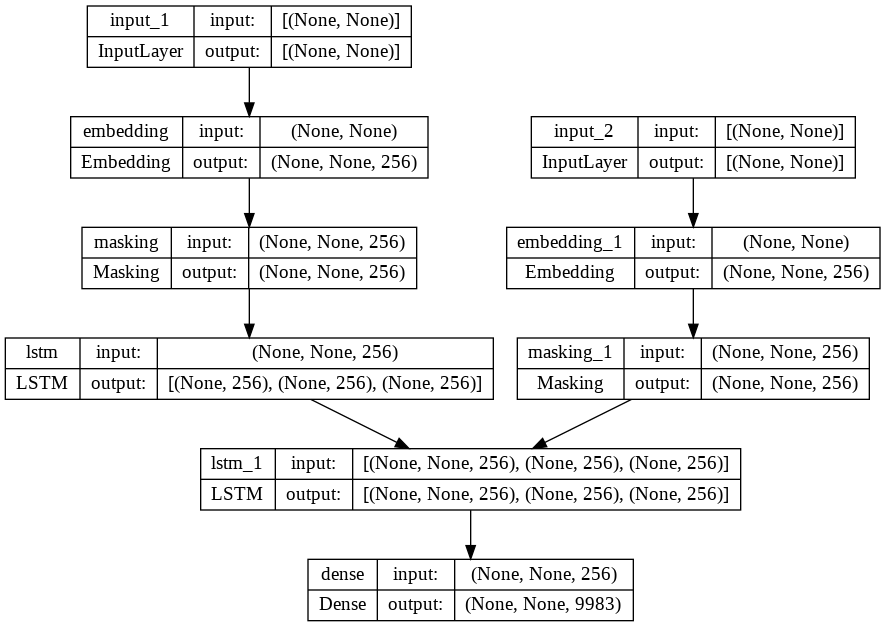

In [19]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

keras API를 보다가 좋은 것을 발견했습니다.

입출력의 크기에서 오류가 났을 때 참고가 많이 됐습니다.

- - -
### 단어 Level 번역기 만들기
- **모델 훈련하기**

In [20]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', verbose=1, patience=10)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50, shuffle=True, callbacks=[es])

Epoch 1/50
235/235 [==============================] - 17s 35ms/step - loss: 1.9046 - val_loss: 1.8439
Epoch 2/50
235/235 [==============================] - 6s 24ms/step - loss: 1.3638 - val_loss: 1.5991
Epoch 3/50
235/235 [==============================] - 6s 24ms/step - loss: 1.1689 - val_loss: 1.4760
Epoch 4/50
235/235 [==============================] - 6s 24ms/step - loss: 1.0583 - val_loss: 1.3988
Epoch 5/50
235/235 [==============================] - 6s 24ms/step - loss: 0.9788 - val_loss: 1.3422
Epoch 6/50
235/235 [==============================] - 6s 24ms/step - loss: 0.9179 - val_loss: 1.3152
Epoch 7/50
235/235 [==============================] - 6s 25ms/step - loss: 0.8671 - val_loss: 1.2867
Epoch 8/50
235/235 [==============================] - 6s 24ms/step - loss: 0.8236 - val_loss: 1.2596
Epoch 9/50
235/235 [==============================] - 6s 24ms/step - loss: 0.7843 - val_loss: 1.2353
Epoch 10/50
235/235 [==============================] - 6s 24ms/step - loss: 0.7477 - val_l

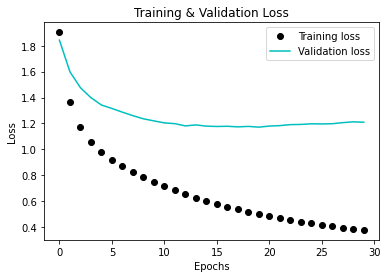

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, 'ko', label='Training loss')
plt.plot(val_loss, 'c', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

민트초코와 오레오 그래프를 재탕해봤습니다.

loss 커브는 적당한 것 같습니다.

- - -
### 번역기 성능 확인하기

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         1232128   
                                                                 
 masking (Masking)           (None, None, 256)         0         
                                                                 
 lstm (LSTM)                 [(None, 256),             525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 1,757,440
Trainable params: 1,757,440
Non-trainable params: 0
_________________________________________________________________


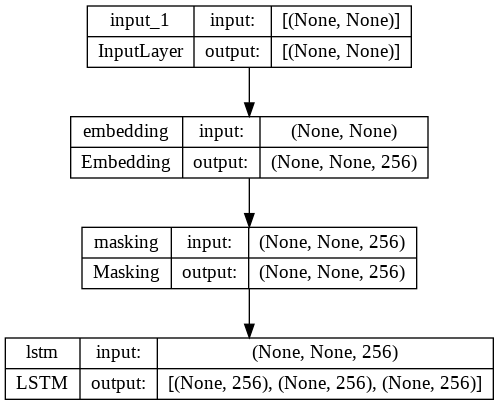

In [22]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

plot_model(encoder_model, show_shapes=True)

번역기 성능을 확인하기 위한 인코더 모델입니다.

In [23]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(hidden_size,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

성능 확인용 디코더 아웃풋 모델을 만들면서 디코더 임베딩 레이어를 재사용해줬습니다.

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    2555648     ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 256)]        0           []                               
                                                                                            

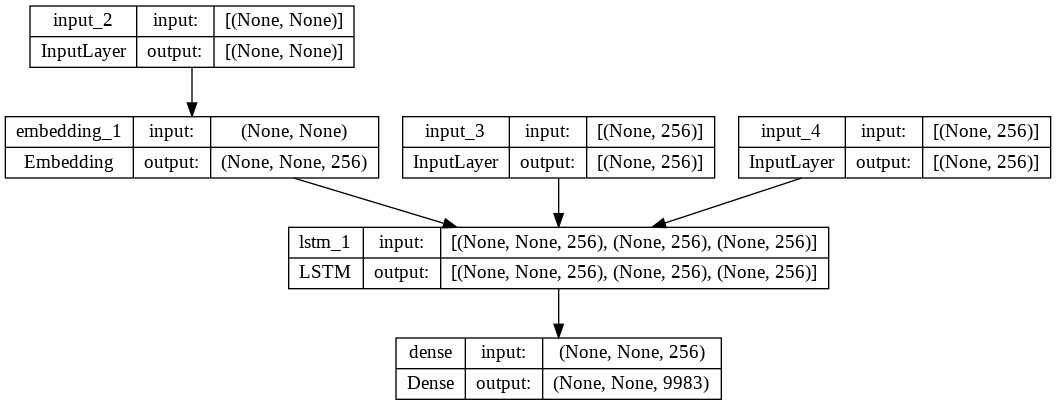

In [24]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

plot_model(decoder_model, show_shapes=True)

번역기 성능을 확인하기 위한 디코더 모델입니다.

In [25]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [26]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['\t']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

영어 문장을 입력받으면 만들었던 번역기 모델로 같은 의미의 프랑스어로 예측하는 메인 함수입니다.

학습한 문장 중에서 랜덤하게 뽑아 5개의 문장을 번역해보겠습니다.

In [27]:
import random

for i in range(5):
    seq_index = random.randint(0, len(encoder_input))

    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index])
    print('번역기가 번역한 문장:', decoded_sentence)

1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: Here is your bag.
정답 문장: Voici ton sac.
번역기가 번역한 문장:  voici ton sac .
1/1 [==============================] - 0s 15ms/step
-----------------------------------
입력 문장: Tom isn't a child.
정답 문장: Tom n'est pas un enfant.
번역기가 번역한 문장:  tom n'est pas un
1/1 [==============================] - 0s 18ms/step
-----------------------------------
입력 문장: It's one of mine.
정답 문장: C'est l'une des miennes.
번역기가 번역한 문장:  c'est l'un des miens
1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: I locked the door.
정답 문장: Je verrouillai la porte.
번역기가 번역한 문장:  je vais la porte
1/1 [==============================] - 0s 18ms/step
-----------------------------------
입력 문장: I just want to cry.
정답 문장: J'ai envie de pleurer.
번역기가 번역한 문장:  je veux juste pleurer


써먹지는 못하겠지만 그래도 직접 만든 번역기 치고는 정확도가 괜찮은 것 같습니다.

이대로 끝내긴 아쉬우니 5개만 더 번역해봅시다.

In [28]:
import random

for i in range(5):
    seq_index = random.randint(0, len(encoder_input))

    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index])
    print('번역기가 번역한 문장:', decoded_sentence)

1/1 [==============================] - 0s 15ms/step
-----------------------------------
입력 문장: I am from Russia.
정답 문장: Je viens de Russie.
번역기가 번역한 문장:  je viens de viens
1/1 [==============================] - 0s 17ms/step
-----------------------------------
입력 문장: He's a bit tipsy.
정답 문장: Il est un peu éméché.
번역기가 번역한 문장:  il est un peu peu
1/1 [==============================] - 0s 15ms/step
-----------------------------------
입력 문장: I love this place.
정답 문장: J'adore cet endroit.
번역기가 번역한 문장:  j'adore cet endroit
1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: Do you feel guilty?
정답 문장: Te sens-tu coupable ?
번역기가 번역한 문장:  vous sentez-vous
1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: You're very funny.
정답 문장: Vous êtes très marrants.
번역기가 번역한 문장:  vous êtes très drôle


제가 만든 모델을 평가해보자면 명사에 대해서는 예측 정확도가 떨어지는 것 같고

프랑스어는 잘 모르지만 먹다, 먹는다, 먹어와 같이 의미는 비슷하지만 조금씩 다른 단어를 많이 헷갈려하는 것 같기도 하고

완전 반대되는 밝다 어둡다 같은 개념의 단어도 서로 비슷하다고 예측하는 것 같습니다.

## 마무리하며

임베딩 레이어 하나 추가하는 게 이렇게 힘들 줄 몰랐습니다.

사실 지금도 오류 없이 잘 작동 된다는 것만 알지 제가 쌓은 레이어가 제대로 돌아가고 있는 지도 모르겠습니다.

마스킹도 예시 코드에는 없었지만 그래도 모듈을 불러오라고 되어있어서 추가해보긴 했지만

레이어를 하나하나 뜯어볼 줄도 몰라서 마스킹이 들어간건지도 모르겠습니다.

번역 결과를 직접 하나하나 보긴 봤는데 큰 차이는 없었던 걸 보면 마스킹이 사실 적용되지 않은 상태일 수도 있겠습니다.

심지어 처음에는 단어 Level 번역기는 원핫인코딩이 필요하지 않다는 것도 긴가민가 했지만 따로 설명은 없었으니 원핫인코딩을 실행해봤습니다.

결과는 메모리 과부화로 LMS도 커널이 죽고, 코랩 마저도 커널이 계속 죽어버렸습니다.

데이터와 파라미터 수를 줄여 억지로 메모리를 살리면 역시 레이어 shape에서 문제가 튀어나왔습니다.

그야말로 오류와의 기나긴 싸움이였던 것 같습니다.

다행히도 keras API를 읽다가 메모해둔 plot_model을 활용해 제가 쌓은 레이어의 구조와 입출력 크기들을 확인할 수가 있어서

원핫인코딩과 임베딩 레이어가 겹친다는 것을 파악하고 끝내 문제를 해결할 수 있었던 것 같습니다.

따지고보면 원핫인코딩이 임베딩 레이어와 같은 역할이라는 간단한 원리도 간과하고 원핫인코딩 코드를 넣으면서 '이거 넣어야 하는 건가?' 싶긴 했는데 왜 진작에 오류의 원인을 파악하지 못했나 싶긴 합니다.

번역기 성능은 솔직히 저게 맞나 싶긴 합니다. 물론 제가 만든 모델이 좋은 건지 나쁜 건지는 저와 같은 방법으로 만든 번역기와 비교를 해봐야 알겠죠.

모델 학습이 잘 돌아갔어도 지금도 어딘가에 번역기로서 맞지 않는 문제가 있을 수도 있습니다.

번역기 성능을 끌어올리기 위해 드랍아웃도 써봤는데요.. 밸로스는 줄어들긴 하는데 번역기에는 쓰면 안될 것 같습니다.

데이터에 중복된 문장을 제거해서 유사도를 떨어뜨려도 봤는데요. 역시 간이 번역기에는 적합한 데이터가 아니게 됐습니다.

코랩만 믿고 33000개가 아닌 전체 데이터를 사용해보기도 했는데, 학습만 길어지고 성능은 거기서 거기였습니다.

앞으로도 점점 예제 복붙은 안통하겠죠..? 슬슬 먹이를 직접 사냥하는 방법을 배우라는 것 같습니다.